# ASTER for emissivity

In [35]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import cryogrid_pytools as cg
from cryogrid_pytools import data, viz
from cryogrid_run_manager import templater

import xarray as xr
import xrspatial
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
bbox = 71.537796,39.62768,71.680705,39.707624
config_url = 'https://docs.google.com/spreadsheets/d/1Ddwt0iciTTzASSlLO3_hmP1ILZmZ2KZInueQsh05ZlQ'

fname_bbox, fname_config = templater.new_run(
    '../runs/abramov-test1', 
    bbox_WSEN=bbox, 
    template_dir='../templates/', 
    config_path_or_url=config_url, 
    sampling=1)

0.00B [00:00, ?B/s]    
SHA256 hash of downloaded file: d91c2a0019756fd505862368eb560759aec5679f64a876dd8468bcf54644b722
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


2025-04-12 08:10:06.294 | INFO     | cryogrid_pytools.excel_config:_get_root_path:70 - Found root path: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test1
2025-04-12 08:10:06.410 | SUCCESS  | cryogrid_pytools.excel_config:__init__:37 - Loaded CryoGrid Excel configuration file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test1/abramov-test1.xlsx
2025-04-12 08:10:06.436 | INFO     | cryogrid_pytools.excel_config:__init__:52 - Start and end times: 1960-01-01 - 2000-01-01
2025-04-12 08:10:07.788 | INFO     | cryogrid_run_manager.templater.data:get_geospatial_data:7 - Getting geospatial data for bbox [71.538, 39.628, 71.681, 39.708]
2025-04-12 08:10:08.381 | WARNING  | cryogrid_pytools.data.shapefiles:get_TPRoGI_rock_glaciers:100 - No rock glaciers found in the bounding box.
2025-04-12 08:10:09.345 | INFO     | cryogrid_pytools.excel_config:_get_root_path:70 - Found root path: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test1
2025-04-12 08:10:09.431 | S

In [36]:
fname_config = '../runs/abramov-test2/abramov-test2.xlsx'
ds = xr.open_dataset('../runs/abramov-test2/forcing/geospatial_data.nc')

In [31]:
slope = xrspatial.slope(ds.elevation).ffill(dim='y').bfill(dim='y').ffill(dim='x').bfill(dim='x')
aspect = xrspatial.aspect(ds.elevation).ffill(dim='y').bfill(dim='y').ffill(dim='x').bfill(dim='x')
aspect_sin = np.sin(np.deg2rad(aspect))
aspect_cos = np.cos(np.deg2rad(aspect))

In [38]:
config = cg.CryoGridConfigExcel(fname_config)

2025-04-11 14:25:37.547 | INFO     | cryogrid_pytools.excel_config:_get_root_path:70 - Found root path: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test2
2025-04-11 14:25:37.606 | SUCCESS  | cryogrid_pytools.excel_config:__init__:37 - Loaded CryoGrid Excel configuration file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test2/abramov-test2.xlsx
2025-04-11 14:25:37.652 | INFO     | cryogrid_pytools.excel_config:check_files_exist:505 - Checking file locations...
2025-04-11 14:25:37.653 | SUCCESS  | cryogrid_pytools.excel_config:check_files_exist:510 - Located file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test2/forcing/albedo.tif
2025-04-11 14:25:37.653 | SUCCESS  | cryogrid_pytools.excel_config:check_files_exist:510 - Located file: /Users/luke/Work/PAMIR/CryoGrid-run-manager/runs/abramov-test2/forcing/snow_index.tif
2025-04-11 14:25:37.653 | SUCCESS  | cryogrid_pytools.excel_config:check_files_exist:510 - Located file: /Users/luke/Work/PAMIR/Cryo

In [ ]:
def def_make_cluster_vars(ds):

    def fill_edges(da):
        """Fill edges of a DataArray with nearest values."""
        # Fill edges in y direction
        da = da.ffill(dim='y').bfill(dim='y')
        # Fill edges in x direction
        da = da.ffill(dim='x').bfill(dim='x')
        return da

    has_slope_aspect = 'CLUSTER_SLOPE_ASPECT' in list(config.get_classes().values())
    has_raw_variables = 'CLUSTER_RAW_VARIABLES' in list(config.get_classes().values())

    cluster_variables = []
    if has_raw_variables:
        for key in config.get_class('CLUSTER_RAW_VARIABLES').iloc[0, 0]:
            if key == 'altitude':
                key = 'elevation'
            cluster_variables += ds[key],

    if has_slope_aspect:
        cluster_variables += xrspatial.slope(ds.elevation).pipe(fill_edges),
        aspect = xrspatial.aspect(ds.elevation).pipe(fill_edges)
        cluster_variables += np.cos(np.deg2rad(aspect)).pipe(fill_edges).rename('aspect_cos'),
        cluster_variables += np.sin(np.deg2rad(aspect)).pipe(fill_edges).rename('aspect_sin'),

    cluster_variables = xr.merge(cluster_variables)

    mask = ds.stratigraphy_index > 0

    cluster_variables = cluster_variables.where(mask)

In [128]:
from sklearn import (
    cluster, 
    metrics,
    pipeline,
    preprocessing,
    model_selection,
)
from cryogrid_run_manager.templater.clustering import FaissKMeans

In [266]:
df = cluster_variables.to_dataframe().dropna()
X = df.pipe(preprocessing.scale)
X = pd.DataFrame(X, columns=df.columns, index=df.index)

/Users/luke/Work/PAMIR/CryoGrid-run-manager/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/luke/Work/PAMIR/CryoGrid-run-manager/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


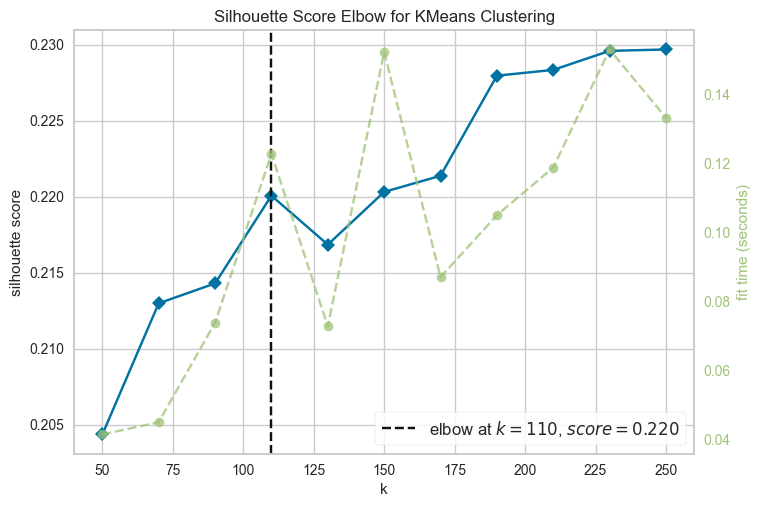

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [275]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, KElbow

n_clusters_list = np.arange(50, 251, 20)

# Instantiate the clustering model and visualizer
km = KMeans(random_state=23)
visualizer = KElbowVisualizer(km, k=n_clusters_list, metric='silhouette')
 
visualizer.fit(X.sample(frac=0.7))        # Fit the data to the visualizer
visualizer.show()

In [280]:
import joblib
from sklearn.cluster import MiniBatchKMeans
from collections import defaultdict

n_clusters_list = np.r_[np.arange(50, 251, 20)]

def get_kmeans_sillhoutte(X, k):
    """Get KMeans silhouette score for a given number of clusters."""
    kmeans = MiniBatchKMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    return metrics.silhouette_score(X, labels)

models = []
scores = defaultdict(list)
for k in n_clusters_list:
    print(k)
    # do multiple runs to get a better estimate of the score
    func = joblib.delayed(get_kmeans_sillhoutte)
    scores[k] += joblib.Parallel(n_jobs=4)(
        func(X, k) for _ in range(20)
    )

50
70
90
110
130
150
170
190
210
230
250


In [281]:
scores = pd.DataFrame(dict(scores)).T

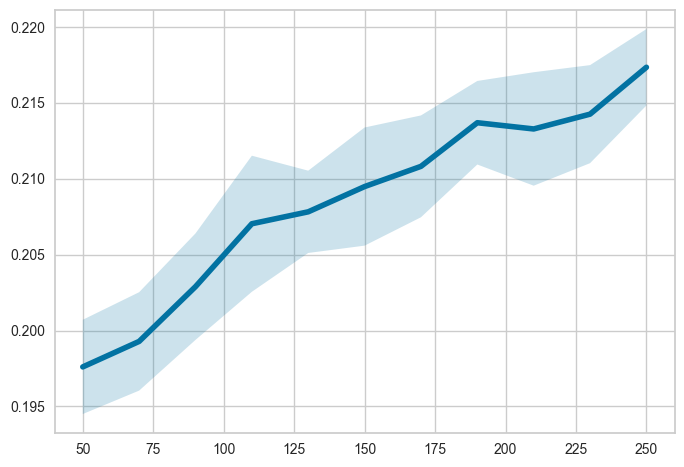

In [282]:
avg = scores.mean(axis=1)
std = scores.std(axis=1)

plt.fill_between(avg.index, avg - std, avg + std, alpha=0.2)
plt.plot(avg.index, avg, label='Silhouette score', lw=4)

In [292]:
from yellowbrick import cluster
from tqdm.dask import TqdmCallback

In [302]:
profile = cg.read_OUT_regridded_files('../runs/abramov-test2/abramov-test2_684_*.mat', deepest_point=-20)

with TqdmCallback():
    profile.load()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


2025-04-12 08:22:55.668 | INFO     | cryogrid_pytools.outputs:read_OUT_regridded_files:230 - Depths are the same for all gridcells. Setting depth as the dimension.


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished


  0%|          | 0/322 [00:00<?, ?it/s]

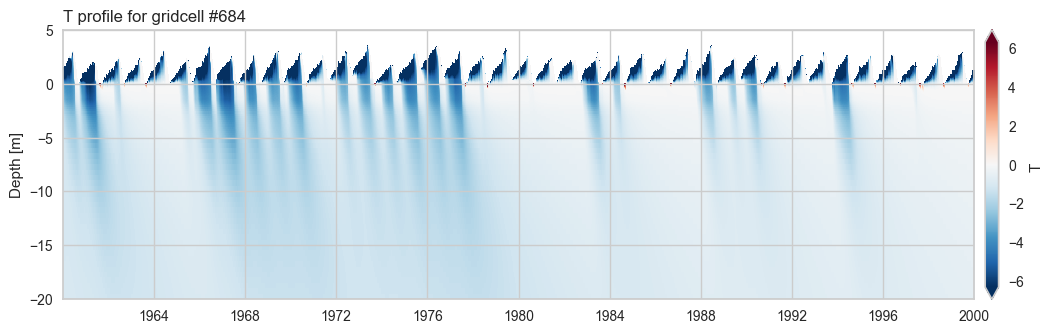

In [303]:
viz.plot_profile(profile.T)